# Numerical computing with functions in Julia
### John Wormell, University of Sydney

## Structure of the talk

* Overview of multiple dispatch
* ForwardDiff: automatic differentiation using dual numbers
* ApproxFun: computing with functions like with vectors

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

# The idea of multiple dispatch

Single dispatch: the same function name (e.g. `append`) calls different methods depending on the type of the *first* argument:

```julia
append!(a::List,b) = ...
append!(a::Dict,b) = ...
append!(a::Set,b) = ... ```

Multiple dispatch: the same function name calls different methods depending on the type of *some or all* of the arguments:

```julia
append!(a::List,b::List) = ... # possibly optimised
append!(a::List,b::Iterable) = ...
append!(a::List,b::Number) = error("Use push!(a,b)")

append!(a::Dict,b::Dict) = ...
append!(a::Dict,keys::List,vals::List) = ...
# etc
```

Methods have a hierarchy of generality:

In [3]:
isrational(x) = false
isrational(x::Rational) = true
isrational(x::Integer) = true

isrational (generic function with 3 methods)

In [4]:
isrational(cos)

false

In [5]:
isrational(1)
isrational(x) = isa(x,Union{Integer,Rational})

true

Julian style: write different (often nested) functions for different types and let the compiler do the work:

In [6]:
bogotimes(a::Float64,b::Float64) = Base.mul_float(a,b) # intrinsic function

bogotimes(a::Float64,b::Vector{Float64}) = [+(a,b[i]) for i in eachindex(b)]
times(a::Float64,b::RowVector{Float64}) = 
    [times(a,b[i]) for i in eachindex(b)]'
times(a::RowVector{Float64},b::Vector{Float64}) = 
    sum([times(a[i],b[i]) for i in eachindex(a)])
 
## etc. etc.

times (generic function with 2 methods)

In [8]:
bogotimes(2.,[1.])  

1-element Array{Float64,1}:
 3.0

Existing functions can be overloaded:

In [17]:
times(a::Complex{Float64}, b::Complex{Float64}) = 
    Complex(a.re*b.re - a.im*b.im, a.re*b.im + a.im*b.re)

times (generic function with 5 methods)

In [15]:
y = 3.+1.0im

3.0 + 1.0im

In [18]:
times(y,y)

8.0 + 6.0im

It's possible to create parametrised families of methods:

In [10]:
times{T,S}(a::T,b::Vector{S}) = 
    [times(a,b[i]) for i in eachindex(b)]
times{T}(a::T,b::T) = Complex(a.re*b.re-a.im*b.im,.dfsdf)
times(a::Number,b::Number) = a*b

times (generic function with 4 methods)

In [11]:
times(3.0+8im,[1.0im,2.0+im])

2-element Array{Complex{Float64},1}:
 -8.0+3.0im 
 -2.0+19.0im

In [21]:
methods(times)

# 9 methods for generic function "times":
times(a::MyComplex, b::MyComplex) in Main at In[19]:5
times(a::Float64, b::Array{Float64,2}) in Main at In[10]:9
times(a::Array{Float64,2}, b::Array{Float64,2}) in Main at In[10]:8
times(a::Array{Float64,2}, b::Array{Float64,1}) in Main at In[10]:7
times(a::Float64, b::Array{Float64,1}) in Main at In[10]:3
times(a::Float64, b::Float64) in Main at In[10]:1
times(a::Float64, b::RowVector{Float64,V} where V<:(AbstractArray{T,1} where T)) in Main at In[10]:4
times(a::RowVector{Float64,V} where V<:(AbstractArray{T,1} where T), b::Array{Float64,1}) in Main at In[10]:5
times(a::T, b::Array{T,1}) where T<:Number in Main at In[20]:1

In [33]:
methods(*)

# 214 methods for generic function "*":
*(x::Bool, z::Complex{Bool}) in Base at complex.jl:236
*(x::Bool, y::Bool) in Base at bool.jl:91
*(x::Bool, y::T) where T<:Unsigned in Base at bool.jl:104
*(x::Bool, z::Complex) in Base at complex.jl:243
*(x::Bool, y::Irrational) in Base at irrationals.jl:111
*(x::Bool, y::T) where T<:Number in Base at bool.jl:101
*(a::Float16, b::Float16) in Base at float.jl:372
*(x::Float32, y::Float32) in Base at float.jl:378
*(x::Float64, y::Float64) in Base at float.jl:379
*(z::Complex{Bool}, x::Bool) in Base at complex.jl:237
*(z::Complex{Bool}, x::Real) in Base at complex.jl:255
*(this::Base.Grisu.Float, other::Base.Grisu.Float) in Base.Grisu at grisu/float.jl:138
*(c::BigInt, x::BigFloat) in Base.MPFR at mpfr.jl:312
*(a::BigInt, b::BigInt, c::BigInt, d::BigInt, e::BigInt) in Base.GMP at gmp.jl:334
*(a::BigInt, b::BigInt, c::BigInt, d::BigInt) in Base.GMP at gmp.jl:327
*(a::BigInt, b::BigInt, c::BigInt) in Base.GMP at gmp.jl:321
*(x::BigInt, y::BigInt) in Base.GMP at gmp.jl:289
*(x::BigInt, c::Union{UInt16, UInt32, UInt64, UInt8}) in Base.GMP at gmp.jl:368
*(x::BigInt, c::Union{Int16, Int32, Int64, Int8}) in Base.GMP at gmp.jl:374
*(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat, e::BigFloat) in Base.MPFR at mpfr.jl:460
*(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat) in Base.MPFR at mpfr.jl:453
*(a::BigFloat, b::BigFloat, c::BigFloat) in Base.MPFR at mpfr.jl:447
*(x::BigFloat, c::BigInt) in Base.MPFR at mpfr.jl:308
*(x::BigFloat, y::BigFloat) in Base.MPFR at mpfr.jl:277
*(x::BigFloat, c::Union{UInt16, UInt32, UInt64, UInt8}) in Base.MPFR at mpfr.jl:284
*(x::BigFloat, c::Union{Int16, Int32, Int64, Int8}) in Base.MPFR at mpfr.jl:292
*(x::BigFloat, c::Union{Float16, Float32, Float64}) in Base.MPFR at mpfr.jl:300
*(B::BitArray{2}, J::UniformScaling) in Base.LinAlg at linalg/uniformscaling.jl:149
*(m1::Measures.Length{:mm,Float64}, m2::Measures.Length{:pct,T} where T) in Plots at /home/juser/.julia/v0.6/Plots/src/layouts.jl:24
*(a::PyCall.PyObject, b) in PyCall at /home/juser/.julia/v0.6/PyCall/src/pyoperators.jl:11
*(z::Complex, w::Complex) in Base at complex.jl:223
*(z::Complex, x::Bool) in Base at complex.jl:244
*(x::Real, z::Complex{Bool}) in Base at complex.jl:254
*(x::Real, z::Complex) in Base at complex.jl:266
*(z::Complex, x::Real) in Base at complex.jl:267
*(x::Rational, y::Rational) in Base at rational.jl:252
*(a::Integer, index::CartesianIndex{N}) where N in Base.IteratorsMD at multidimensional.jl:83
*(c::Union{UInt16, UInt32, UInt64, UInt8}, x::BigInt) in Base.GMP at gmp.jl:372
*(c::Union{Int16, Int32, Int64, Int8}, x::BigInt) in Base.GMP at gmp.jl:378
*(c::Union{UInt16, UInt32, UInt64, UInt8}, x::BigFloat) in Base.MPFR at mpfr.jl:288
*(c::Union{Int16, Int32, Int64, Int8}, x::BigFloat) in Base.MPFR at mpfr.jl:296
*(c::Union{Float16, Float32, Float64}, x::BigFloat) in Base.MPFR at mpfr.jl:304
*(x::Irrational, y::Irrational) in Base at irrationals.jl:109
*(y::Real, x::Base.Dates.Period) in Base.Dates at dates/periods.jl:88
*(x::Real, r::Base.Use_StepRangeLen_Instead) in Base at deprecated.jl:1226
*(x::Real, ::Type{X}) where X<:FixedPointNumbers.FixedPoint in FixedPointNumbers at /home/juser/.julia/v0.6/FixedPointNumbers/src/FixedPointNumbers.jl:43
*(x::FixedPointNumbers.Fixed{T,f}, y::FixedPointNumbers.Fixed{T,f}) where {T, f} in FixedPointNumbers at /home/juser/.julia/v0.6/FixedPointNumbers/src/fixed.jl:36
*(x::T, y::T) where T<:FixedPointNumbers.Normed in FixedPointNumbers at /home/juser/.julia/v0.6/FixedPointNumbers/src/normed.jl:91
*(n::Integer, ::FixedPointNumbers.NormedConstructor{T,f}) where {T, f} in FixedPointNumbers at /home/juser/.julia/v0.6/FixedPointNumbers/src/deprecations.jl:35
*(x::Number) in Base at operators.jl:400
*(y::Number, x::Bool) in Base at bool.jl:106
*(x::T, y::T) where T<:Union{Int128, UInt128} in Base at int.jl:571
*(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:33
*(x::T, y::T) wh

## Dual numbers and ForwardDiff

In [12]:
using DualNumbers

In [2]:
methods(append!)

# 17 methods for generic function "append!":
append!(B::BitArray{1}, items::BitArray{1}) in Base at bitarray.jl:781
append!(B::BitArray{1}, items::AbstractArray{Bool,1}) in Base at bitarray.jl:796
append!(A::Array{Bool,1}, items::BitArray{1}) in Base at bitarray.jl:797
append!(a::PyCall.PyObject, items::PyCall.PyObject) in PyCall at /Users/johnwormell/.julia/v0.6/PyCall/src/PyCall.jl:809
append!(a::PyCall.PyObject, items) in PyCall at /Users/johnwormell/.julia/v0.6/PyCall/src/PyCall.jl:803
append!(a::Array{#s45,1} where #s45, items::AbstractArray{T,1} where T) in Base at array.jl:630
append!(a::Array{T,1} where T, iter) in Base at array.jl:637
append!(cb::DataStructures.CircularBuffer, datavec::AbstractArray{T,1} where T) in DataStructures at /Users/johnwormell/.julia/v0.6/DataStructures/src/circular_buffer.jl:63
append!(h::StatsBase.AbstractHistogram{T,1,E} where E, v::AbstractArray{T,1} where T) where T in StatsBase at /Users/johnwormell/.julia/v0.6/StatsBase/src/hist.jl:221
append!(h::StatsBase.AbstractHistogram{T,1,E} where E, v::AbstractArray{T,1} where T, wv::AbstractArray{T,1} where T) where T in StatsBase at /Users/johnwormell/.julia/v0.6/StatsBase/src/hist.jl:222
append!(h::StatsBase.AbstractHistogram{T,N,E} where E, vs::Tuple{Vararg{AbstractArray{T,1} where T,N}}) where {T, N} in StatsBase at /Users/johnwormell/.julia/v0.6/StatsBase/src/hist.jl:258
append!(h::StatsBase.AbstractHistogram{T,N,E} where E, vs::Tuple{Vararg{AbstractArray{T,1} where T,N}}, wv::StatsBase.AbstractWeights) where {T, N} in StatsBase at /Users/johnwormell/.julia/v0.6/StatsBase/src/hist.jl:271
append!(h::StatsBase.AbstractHistogram{T,N,E} where E, vs::Tuple{Vararg{AbstractArray{T,1} where T,N}}, wv::AbstractArray{T,1} where T) where {T, N} in StatsBase at /Users/johnwormell/.julia/v0.6/StatsBase/src/hist.jl:265
append!(plt::Plots.Plot, i::Integer, y::AbstractArray{T,1} where T) in Plots at /Users/johnwormell/.julia/v0.6/Plots/src/utils.jl:889
append!(plt::Plots.Plot, i::Integer, x::AbstractArray{T,1} where T, y::AbstractArray{T,1} where T) in Plots at /Users/johnwormell/.julia/v0.6/Plots/src/utils.jl:904
append!(plt::Plots.Plot, i::Integer, x::AbstractArray{T,1} where T, y::AbstractArray{T,1} where T, z::AbstractArray{T,1} where T) in Plots at /Users/johnwormell/.julia/v0.6/Plots/src/utils.jl:919
append!(a::PyCall.PyVector{T}, items) where T in PyCall at /Users/johnwormell/.julia/v0.6/PyCall/src/conversions.jl:278

Dual numbers extend the real numbers like complex numbers do, but the "imaginary" number $\varepsilon$ has the property that 
\\[ \varepsilon^2 = 0. \\]

In [13]:
ε*4, (3+2ε)*(ε+2)

(0 + 4ɛ, 6 + 7ɛ)

The number $\varepsilon$ can be thought of as a very small real number. 

Dual numbers behave like first-order Taylor series:

In [67]:
(1+ε)^2, (1+ε)^3

(1 + 2ɛ, 1 + 3ɛ)

In [68]:
sin(π/6+ε) == sin(π/6)+cos(π/6)*ε

true

Hence, if we can call a (possibly complex) function $f$ with a dual number, we can find its derivative as
\\[ f(x+y\varepsilon) = f(x) + f'(x)y\varepsilon \\]

In [17]:
# 10 iterates of the logistic map
function f(x)
    for i = 1:10
        x = 3.8*x*(1-x)
    end
    x
end
x0 = 0.95
f(x0+ε)

0.5731744628003645 - 104.3452650128117ɛ

In [18]:
using ForwardDiff

In [21]:
ForwardDiff.derivative(f,x0)
dfdx = x->ForwardDiff.derivative(f,x)
ForwardDiff.derivative(dfdx,x0)

490209.9514631049

In [29]:
eval(:(4+12))

16

## ApproxFun

In [30]:
using ApproxFun

ApproxFun approximates functions by generalised Fourier series:

In [35]:
f_fun = Fun(f,Chebyshev(0..1))

Fun(Chebyshev(【0.0,1.0】),[0.640749, -1.05896e-14, 0.00827331, -9.93887e-15, -0.0139394, -1.05346e-14, 0.00968527, -1.0182e-14, -0.0321085, -9.59686e-15  …  3.07707e-15, 3.54987e-16, 2.79898e-15, 7.68156e-16, 2.48243e-15, 3.55543e-19, 1.58951e-15, 6.93872e-16, 5.5645e-16, 8.60649e-17])

These representations are:
* very efficient (coefficients decay as fast as exponentially)
* very fast (using FFT)


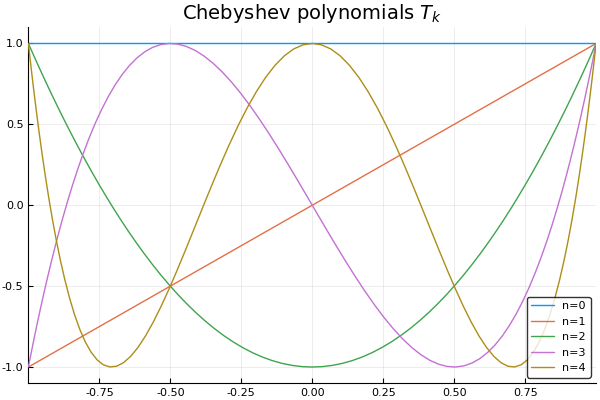

In [75]:
plt = plot(title="Chebyshev polynomials \$T_k\$")
for i = 1:5
    plt = plot!(
        Fun(Chebyshev(-1..1),[zeros(i-1);1;zeros(10)]),show=true,
        label="n=$(i-1)",ylim=(-1.1,1.1))
end
plt


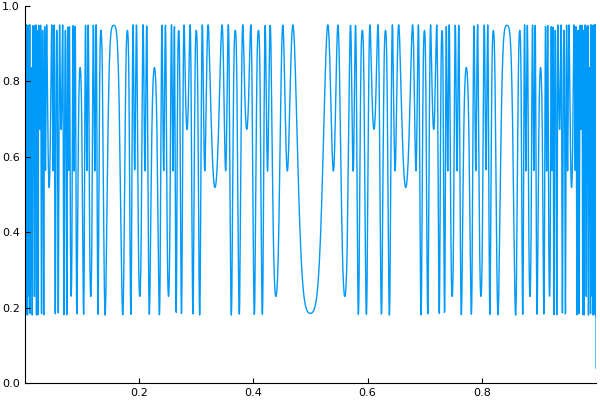

In [36]:
plot(f_fun,legend=:none,grid=:none,ylim=(0,1))

In [37]:
ncoefficients(f_fun)

1024

Range of spaces/domains:

In [467]:
Fun(sin,Chebyshev(0..1)) # default for interval 0..1
Fun(sin,Legendre(0..1))
Fun(sin,Fourier(PeriodicInterval(0.,2pi)))
Fun(x->[sin(x),cos(x)],Taylor(Circle(0,1.)))
Fun((x,y)->cos(x*exp(y)),Chebyshev(0..1)*Legendre(0..1))

Fun(Chebyshev(【0.0,1.0】)⊗Legendre(【0.0,1.0】),[0.534387, -0.354916, -0.587355, -0.0650675, -0.422032, -0.0979239, 0.00402483, -0.0587719, -0.0312475, 0.0260338  …  -2.49841e-17, 1.68473e-17, 1.18093e-17, 7.95992e-18, 2.40111e-18, 1.37479e-18, -4.63967e-18, -8.52242e-18, 1.70933e-15, 3.06873e-15])

Most function operations are possible:

In [48]:
g = Fun(x->sqrt(sin(x)+1)-10airyai(-7x^2),Legendre(0..2))
# plot(g,label="g"); 
# plot!(cumsum(g),label="integral of g") # partial integral
# sample(abs(g),10)
f2 = sum(abs(g))

LoadError: [91mInterruptException:[39m

Since ApproxFun treats functions like vectors, it also treats operators (e.g. differentiation) like (usually sparse) matrices:

In [49]:
sp = Chebyshev(0..1)
Derivative(sp)#*Fun(exp,sp)

ConcreteDerivative:Chebyshev(【0.0,1.0】)→Ultraspherical(1,【0.0,1.0】)
   2.0                                                
        4.0                                           
             6.0                                      
                  8.0                                 
                       10.0                           
                             12.0                     
                                   14.0               
                                         16.0         
                                               18.0   
                                                     ⋱
                                                     ⋱

This lets you solve linear problems using \ overloads:
\begin{array}{rcl} u'' + e^x u &= 0 \\ u(0) &= 1 \\ u'(0) &= 0 \end{array}

In [51]:
d = 0..6
B = [ldirichlet(d);lneumann(d)]
L = Derivative(d)^2+Fun(exp,d)

u = [B;L]\[1;0;Fun(zero,d)]
eigvals(L,60)

38-element Array{Complex{Float64},1}:
  197.271+0.0im    
  159.428+0.0im    
  126.977+0.0im    
  101.125+0.0im    
  95.7566+19.4187im
  95.7566-19.4187im
  81.0523+47.1728im
  81.0523-47.1728im
  59.0348+65.8644im
  59.0348-65.8644im
  78.1609+0.0im    
  67.2436+0.0im    
  62.3432+15.2372im
         ⋮         
  2.77875+79.7889im
  2.77875-79.7889im
 -9.40312+82.4213im
 -9.40312-82.4213im
 -22.3153+83.611im 
 -22.3153-83.611im 
 -36.3429+83.4596im
 -36.3429-83.4596im
 -68.1053+78.1347im
 -68.1053-78.1347im
 -51.5468+81.7277im
 -51.5468-81.7277im


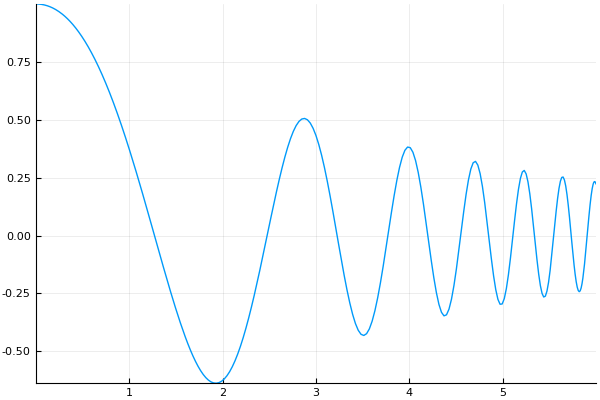

In [55]:
plot(u,legend=false)

Also possible: Newton iteration

In [56]:
D = ApproxFun.Derivative(d)
N = u -> [u(-10),u'*u'-(0.1u*u*u*u+u*u+1)]
g = newton(N,Fun(x->sin(x-10),d))

LoadError: [91mArgumentError: tolerance must be less than 1[39m

In [419]:
using Poltergeist
lanford = modulomap(x->2x+x*(1-x)/2,0..1)
eigvals(Transfer(lanford)*Multiplication(Fun(exp,0..1),sp),30)

4-element Array{Complex{Float64},1}:
  2.01246+0.0im
  1.35942+0.0im
 0.909849+0.0im
 0.607472+0.0im

## Conclusion

* Multiple dispatch does a lot of work in Julia, especially extending classes of functions to new types
* One can "reach into" functions in an automatic way (ForwardDiff)
